In [ ]:

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from google.colab import files


uploaded = files.upload()
file_name = next(iter(uploaded))
print(f"\nFirst 5 rows of uploaded file:")
df = pd.read_csv(file_name)
print(df.head())



label_candidates = [col for col in df.columns if 'label' in col.lower()]
if not label_candidates:
    raise ValueError("No label column found - please check your dataset")

print(f"\nDetected possible label columns: {label_candidates}")
label_col = label_candidates[0]  
print(f"Using column '{label_col}' as label")


df.columns = df.columns.str.strip().str.lower().str.replace('[^a-z0-9]', '_', regex=True)
label_col = label_col.strip().lower().replace('[^a-z0-9]', '_', regex=True)


df = df.dropna()


unique_labels = df[label_col].unique()
print(f"\nUnique labels found: {unique_labels}")

label_mapping = {
    'benign': 0,
    'web_attack_brute_force': 1,
    'web_attack_sql_injection': 2,
    'web_attack_xss': 3
}


actual_mapping = {}
for lbl in unique_labels:
    clean_lbl = str(lbl).strip().lower().replace(' ', '_')
    for key in label_mapping:
        if key in clean_lbl:
            actual_mapping[lbl] = label_mapping[key]
            break
    else:
        actual_mapping[lbl] = 0  

df['label_encoded'] = df[label_col].map(actual_mapping)


X = df.select_dtypes(include=np.number).drop('label_encoded', axis=1, errors='ignore')
y = df['label_encoded']

print(f"\nFinal feature matrix shape: {X.shape}")
print(f"Class distribution:\n{y.value_counts()}")



Saving WebAttacks.pcap_ISCX.csv to WebAttacks.pcap_ISCX (1).csv

First 5 rows of uploaded file:
    Destination Port   Flow Duration   Total Fwd Packets  \
0                389       113095465                  48   
1                389       113473706                  68   
2                  0       119945515                 150   
3                443        60261928                   9   
4                 53             269                   2   

    Total Backward Packets  Total Length of Fwd Packets  \
0                       24                         9668   
1                       40                        11364   
2                        0                            0   
3                        7                         2330   
4                        2                          102   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                         10012                     403   
1                         12718                     403   
2          

TypeError: str.replace() takes no keyword arguments

Saving WebAttacks.pcap_ISCX.csv to WebAttacks.pcap_ISCX (4).csv
Original label categories: ['BENIGN' 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection']

Encoded label distribution:
label_encoded
0    168186
1      1507
3       652
2        21
Name: count, dtype: int64
Epoch 1/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 191s 395ms/step - accuracy: 0.6161 - loss: 4.1186e-05 - val_accuracy: 0.6643 - val_loss: 1.4135
Epoch 2/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 198s 424ms/step - accuracy: 0.6995 - loss: 4.1081e-05 - val_accuracy: 0.7477 - val_loss: 0.8040
Epoch 3/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 184s 386ms/step - accuracy: 0.7927 - loss: 3.0267e-05 - val_accuracy: 0.7516 - val_loss: 0.7366
Epoch 4/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 197s 424ms/step - accuracy: 0.7985 - loss: 2.5125e-05 - val_accuracy: 0.7918 - val_loss: 0.6092
Epoch 5/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 197s 424ms/step - accuracy: 0.8352 - loss: 2.4448e-05 - val_accuracy: 0.7997 - val_loss: 0.6624
Epoch 6/10
466/466 ━━━━━━

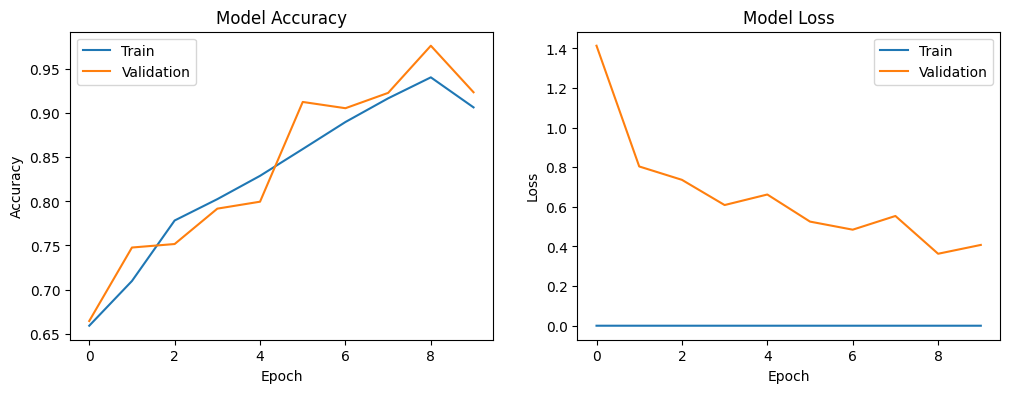

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step



Sample Prediction:
Predicted: BENIGN (95.3% confidence)
Actual: BENIGN


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from google.colab import files
import matplotlib.pyplot as plt


uploaded = files.upload()
file_name = next(iter(uploaded))
df = pd.read_csv(file_name)


df = df.rename(columns={' Label': 'Label'}) 
print("Original label categories:", df['Label'].unique())


le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['Label'])
print("\nEncoded label distribution:")
print(df['label_encoded'].value_counts())


X = df.select_dtypes(include=np.number).drop('label_encoded', axis=1, errors='ignore')
y = df['label_encoded']


X = X.replace([np.inf, -np.inf], np.nan).fillna(0)


scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)


def create_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=(input_shape, 1))

   
    x = tf.keras.layers.Dense(64, activation='swish')(inputs)
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(32, return_sequences=True)
    )(x)
    x = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=8)(x, x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(inputs, outputs)

model = create_model(X_train.shape[1], len(le.classes_))


class_counts = np.bincount(y_train)
class_weights = {i: 1./count for i, count in enumerate(class_counts)}

model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=3e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    X_train[..., np.newaxis],
    y_train,
    validation_data=(X_test[..., np.newaxis], y_test),
    epochs=10,
    batch_size=256,
    class_weight=class_weights
)


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


sample_idx = 0  
sample = X_test[sample_idx][np.newaxis, ..., np.newaxis]
pred = model.predict(sample)
print(f"\nSample Prediction:")
print(f"Predicted: {le.inverse_transform([np.argmax(pred)])[0]} ({np.max(pred):.1%} confidence)")
print(f"Actual: {le.inverse_transform([y_test.iloc[sample_idx]])[0]}")


model.save('web_attack_detection_model.h5')
files.download('web_attack_detection_model.h5')

1598/1598 ━━━━━━━━━━━━━━━━━━━━ 45s 28ms/step


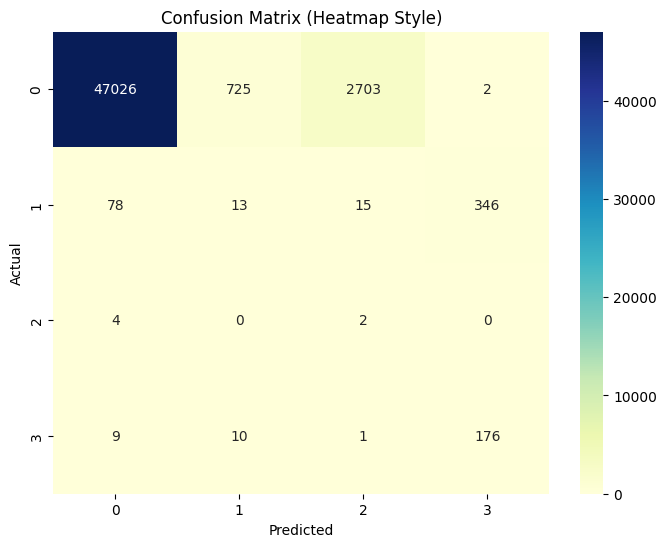

<Figure size 800x600 with 0 Axes>

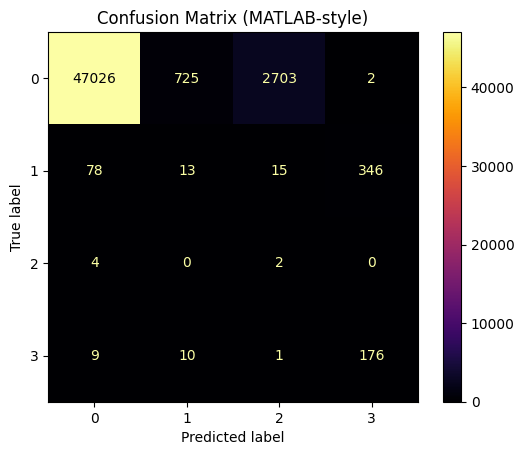

Classification Report:

                            precision    recall  f1-score   support

                    BENIGN       1.00      0.93      0.96     50456
  Web Attack � Brute Force       0.02      0.03      0.02       452
Web Attack � Sql Injection       0.00      0.33      0.00         6
          Web Attack � XSS       0.34      0.90      0.49       196

                  accuracy                           0.92     51110
                 macro avg       0.34      0.55      0.37     51110
              weighted avg       0.99      0.92      0.95     51110



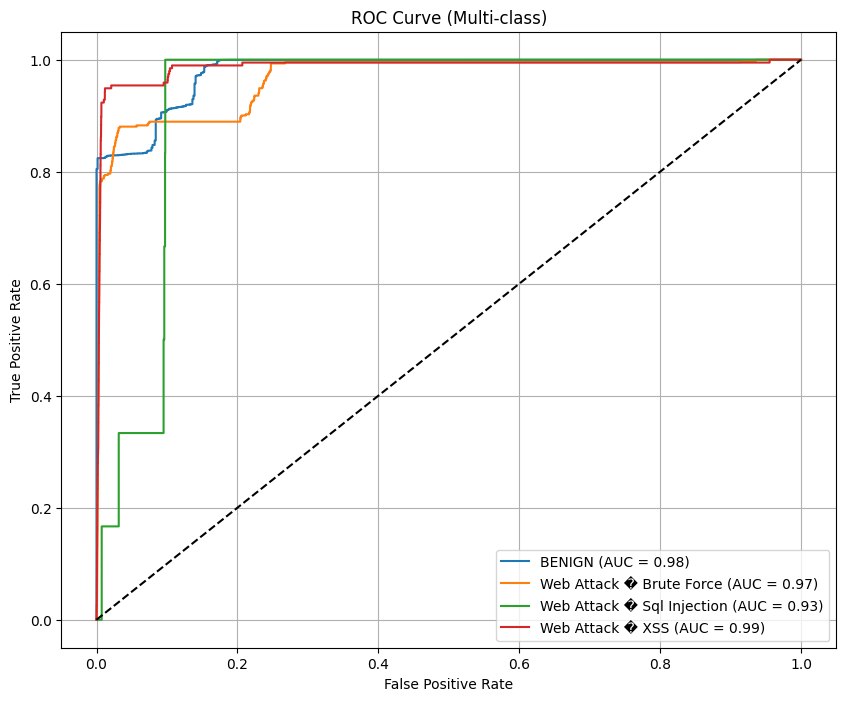

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc, roc_auc_score
from tensorflow.keras.utils import to_categorical


y_pred_prob = model.predict(X_test[..., np.newaxis])
y_pred = np.argmax(y_pred_prob, axis=1)


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', cbar=True)
plt.title('Confusion Matrix (Heatmap Style)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.inferno)
plt.title('Confusion Matrix (MATLAB-style)')
plt.grid(False)
plt.show()


print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))


y_test_cat = to_categorical(y_test, num_classes=len(le.classes_))

plt.figure(figsize=(10, 8))
for i in range(len(le.classes_)):
    fpr, tpr, _ = roc_curve(y_test_cat[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{le.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve (Multi-class)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
